In [1]:
%cd ..

/Users/heilman/galvanize/recipe-vectorizer


In [4]:
from src.functions import *
from src.modeling_functions import *
import numpy as np
import networkx as nx
import pandas as pd
from collections import Counter
from string import *
from sklearn.metrics.pairwise import cosine_similarity
from sys import argv, exit
import pymongo
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import imageio
import time
import warnings
warnings.filterwarnings("ignore")

In [69]:
def plot_weighted_graph(G, ax, k=0.5, fixed_axes=None):

    betweenness = nx.edge_betweenness_centrality(G)
    between_array = np.array([val for key, val in betweenness.items()])
    edge_colors = [cm.jet(bet/np.max(between_array)) for bet in between_array]

    spring = nx.spring_layout(G, k=k, weight='weight', seed=427)
    
    for subG in nx.connected_component_subgraphs(G):
        try:
            eigen_centralities = nx.eigenvector_centrality(subG)
            eigen_array = np.array([val for key, val in eigen_centralities.items()])
            node_colors = [cm.jet(eig/np.max(eigen_array)) for eig in eigen_array]
            node_sizes = 80 * eigen_array/np.max(eigen_array) + 10
        except:
            node_colors = cm.jet(0)
            node_sizes = 10
        nx.draw_networkx_nodes(subG,
                               pos=spring,
                               node_size=node_sizes,
                               node_color=node_colors,
                               ax=ax,
                               alpha=0.5,
                               with_labels=False)
    nx.draw_networkx_edges(G,
                           pos=spring,
                           edge_color=edge_colors,
                           width=8 * between_array/np.max(between_array) + 0.1,
                           alpha=0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if fixed_axes:
        ax.set_xlim(left=fixed_axes[0], right=fixed_axes[1])
        ax.set_ylim(bottom=fixed_axes[2], top=fixed_axes[3])

In [54]:
search_term = 'chili'
n_recipes = 4

min_cluster_size = 10

mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

print('Searching for {} recipes...'.format(search_term))
recipes, ratings = find_recipes_matching_search(recipes_coll, search_term)
print('{} recipes found.'.format(len(recipes)))

df = create_dataframe(recipes)
X = df.values
cosine_sims = cosine_similarity(X)

G = create_graph(cosine_sims, threshold=0.75)
remove_isolates(G, min_cluster_size)

graphs = [G.copy()]
n_subgraphs = nx.number_connected_components(G)
print('{} clusters identified.'.format(n_subgraphs))
while n_subgraphs < n_recipes:
    largest_subgraph = max(nx.connected_component_subgraphs(G), key=len)
    graphs += split_subgraph(largest_subgraph, G, return_history=True)
    remove_isolates(G, min_cluster_size)
    new_n = nx.number_connected_components(G)
    if n_subgraphs < new_n:
        print('{} clusters identified.'.format(new_n))
    n_subgraphs = new_n
    if len(G) <= min_cluster_size:
        break

recipe_names_in_cluster = []
for component in nx.connected_components(G):
    recipe_names_in_cluster.append(get_recipe_names(component, df.index, recipes))

cluster_keywords = []
for names in recipe_names_in_cluster:
    cluster_keywords.append(find_keywords(names, limit=4))

recipe_results = generate_recipes(G, df)

for i, r in enumerate(recipe_results):
    print('\nRecipes in cluster (5 of {}) :'.format(len(recipe_names_in_cluster[i])))
    print(recipe_names_in_cluster[i][:5])
    print('\nCluster keywords :')
    print(cluster_keywords[i])
    print('\nSuggested recipe :')
    print(r)
    print('--------------------------------')

Searching for chili recipes...
296 recipes found.
1 clusters identified.
2 clusters identified.
3 clusters identified.
4 clusters identified.

Recipes in cluster (5 of 97) :
['The Best Vegetarian Chili in the World', 'Easy Chili I', "Debdoozie's Blue Ribbon Chili", "Just Like Wendy's® Chili", "Frank's Spicy Alabama Onion Beer Chili"]

Cluster keywords :
[('chili', 95), ('easy', 6), ('vegetarian', 5), ('spicy', 5)]

Suggested recipe :
onion               1.123545
tomato              3.304740
chili powder        0.106682
kidney beans        1.984211
garlic              0.146014
beef                1.810246
cumin               0.031798
bell pepper         0.428427
tomato sauce        0.848530
salt                0.011225
oregano             0.011127
black pepper        0.006120
water               0.488025
tomato paste        0.183468
olive oil           0.024497
cayenne pepper      0.004971
celery              0.066792
vegetable oil       0.029698
jalapeno pepper     0.026581
red pepper 

In [83]:
def plot_weighted_graph_high_res(G, ax, k=0.5, fixed_axes=None):

    betweenness = nx.edge_betweenness_centrality(G)
    between_array = np.array([val for key, val in betweenness.items()])
    edge_colors = [cm.jet(bet/np.max(between_array)) for bet in between_array]

    spring = nx.spring_layout(G, k=k, weight='weight', seed=427)
    
    for subG in nx.connected_component_subgraphs(G):
        try:
            eigen_centralities = nx.eigenvector_centrality(subG)
            eigen_array = np.array([val for key, val in eigen_centralities.items()])
            node_colors = [cm.jet(eig/np.max(eigen_array)) for eig in eigen_array]
            node_sizes = 800 * eigen_array/np.max(eigen_array) + 250
        except:
            node_colors = cm.jet(0)
            node_sizes = 10
        nx.draw_networkx_nodes(subG,
                               pos=spring,
                               node_size=node_sizes,
                               node_color=node_colors,
                               ax=ax,
                               alpha=0.5,
                               with_labels=False)
    nx.draw_networkx_edges(G,
                           pos=spring,
                           edge_color=edge_colors,
                           width=20 * between_array/np.max(between_array) + 2,
                           alpha=0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if fixed_axes:
        ax.set_xlim(left=fixed_axes[0], right=fixed_axes[1])
        ax.set_ylim(bottom=fixed_axes[2], top=fixed_axes[3])

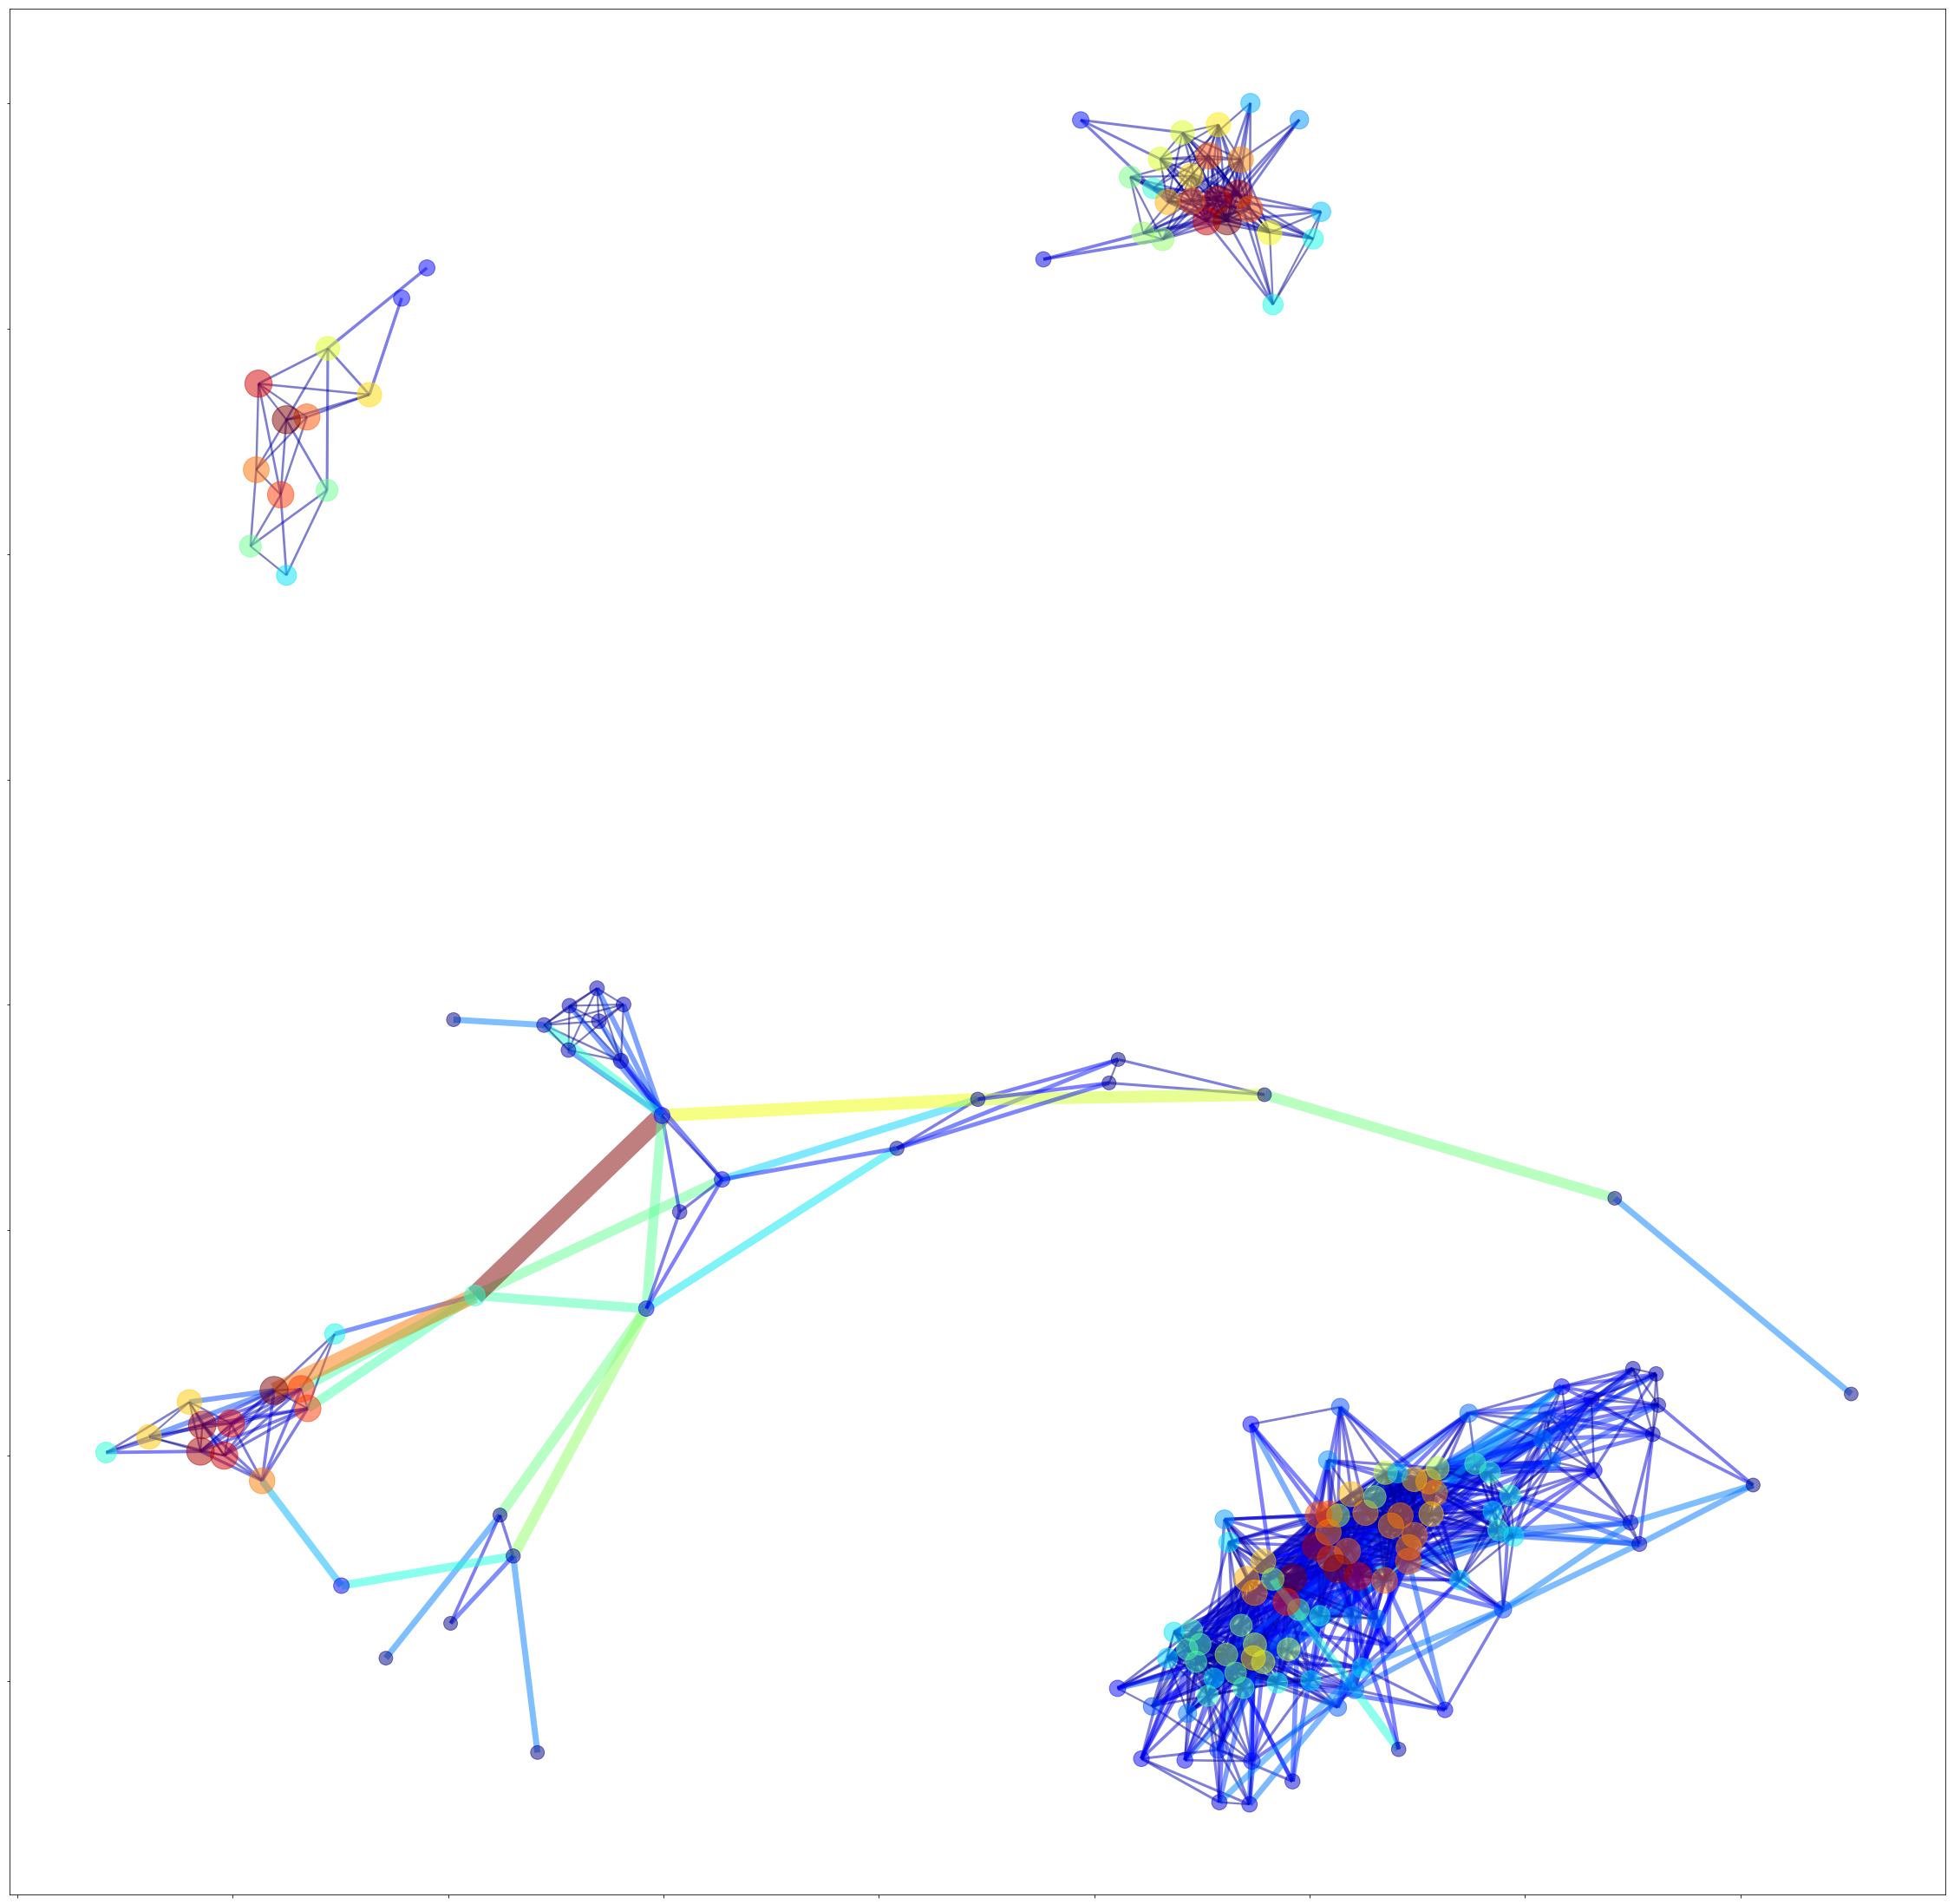

In [87]:
fig, ax = plt.subplots(figsize=(40,40))
plot_weighted_graph_high_res(graphs[-1], ax, k=0.5)
fig.canvas.draw()
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
imageio.imsave('images/chili_final.png', img)

In [86]:
len(graphs)

429

In [55]:
frames = []
print('0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%')
print('|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|')
for i,graph in enumerate(graphs):
    pct = int((i/len(graphs)) * 100)
    print('|{0}{1}| {2}% complete'.format('='*pct, '.'*(99-pct),pct), end='\r')
    fig, ax = plt.subplots(figsize=(12,12))
    plot_weighted_graph(graph, ax, k=0.5, fixed_axes=(-1.00, 1.00, -1, 1))
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    frames.append(img)
    if i==0 or i==len(graphs)-1:
        for _ in range(10):
            frames.append(img)
    pct = int(((i+1)/len(graphs)) * 100)
    s = '='*pct if pct != 100 else '='*99
    print('|{0}{1}| {2}% complete'.format(s, '.'*(99-pct),pct), end='\r')
    
imageio.mimsave('images/chili-4.gif', frames, duration=0.2)

0%       10%       20%       30%       40%       50%       60%       70%       80%       90%       100%
|_________|_________|_________|_________|_________|_________|_________|_________|_________|_________|


In [56]:
imageio.mimsave('images/chili-4-fast.gif', frames, duration=0.1)

In [89]:
recipe_names_in_cluster[0]

['The Best Vegetarian Chili in the World',
 'Easy Chili I',
 "Debdoozie's Blue Ribbon Chili",
 "Just Like Wendy's® Chili",
 "Frank's Spicy Alabama Onion Beer Chili",
 'Washabinaros Chili',
 'Chili I',
 'Best Damn Chili',
 'My Chili',
 'Paleo Chili',
 'Quick Chili I',
 'Alligator Chili',
 'Polish Chili',
 "JRay's Chili",
 'Chili-ghetti',
 'Seafood Chili',
 "Melanie's Chili",
 "John's Chili",
 'Killer Chili',
 'Fruity Chili',
 'Hearty Chili',
 'Chili with Quinoa',
 'Homemade Chili',
 "Fairuzah's Chili",
 "Kas' Chili",
 "Kelly's Chili",
 'Tequila Chili',
 'Steak Chili',
 'Chili IV',
 "Mama's Chili",
 'Camp Chili',
 'Chicken Chili',
 'MVP Chili',
 'Lentil Chili',
 "Miner's Chili",
 'Simple Turkey Chili',
 'Habanero Hellfire Chili',
 'Butternut Squash and Turkey Chili',
 'Easy Texas Chili',
 'Three-Bean Vegetarian Chili',
 'Sweet Potato Chili',
 'Award Winning Chili',
 'Quick and Spicy Chili',
 'Spicy Slow-Cooked Chili',
 'Chicken Chili Soup',
 'Wicked Good Veggie Chili',
 'Slow Cooker Chip